# Análisis Espacial de Hotspots de Crimen en Birmingham (2023): Coropletas LSOA, Densidad Kernel y Proximidad a POI

**Autor:** Jhonfred Galarraga

**Fecha:** Abril 2025

## 1. Introducción
Este proyecto realiza un análisis multifacético de los datos de crímenes reportados a la policía de West Midlands que ocurrieron dentro de la ciudad de Birmingham durante el año 2023. El objetivo es identificar, visualizar y comparar patrones de concentración espacial de incidentes delictivos (hotspots) utilizando diversas técnicas de análisis geoespacial.

Se emplearon las siguientes herramientas y librerías principales:

* **Python:** Como lenguaje base para el análisis.

* **Pandas:** Para la carga, limpieza y manipulación de datos tabulares.

* **GeoPandas:** Esencial para el manejo de datos vectoriales (LSOAs, POIs, puntos de crimen), reproyecciones y uniones espaciales.

* **Matplotlib:** Para generar visualizaciones estáticas (gráficos de barras, mapas de coropletas base).

* **Mapclassify:** Para aplicar esquemas de clasificación (Natural Breaks) en los mapas de coropletas y mejorar la representación de datos sesgados.

* **OSMnx:** Para descargar datos de Puntos de Interés (POI) directamente desde OpenStreetMap.

* **QGIS (v. 3.40.3):** Utilizado para la generación y estilización avanzada del mapa de Densidad Kernel (KDE) y la creación del producto cartográfico final.

* **Google Colab:** Como entorno de desarrollo interactivo.

El análisis abarca tres enfoques complementarios:

1. Agregación de crímenes por LSOA y visualización mediante mapas de coropletas (general y por tipo de crimen).

2. Estimación de Densidad Kernel (KDE) para obtener una visión continua de los hotspots basada en puntos.

3. Análisis de proximidad a Puntos de Interés (POI) seleccionados (Bares/Pubs, Comisarías, Estaciones).

## 2. Adquisición y Descripción de Datos

Se utilizaron las siguientes fuentes de datos principales:

1.  **Datos de Crímenes:**
    *   **Fuente:** Descargados desde Kaggle, originarios de data.police.uk. Archivos CSV pre-divididos por fuerza policial.
    *   **Archivo Específico:** CSV correspondiente a West Midlands Police para 2023 (ej. 2023-01-west-midlands-street.csv y archivos subsecuentes si se combinaron).
    *   **Columnas Clave Usadas:** Latitude, Longitude, LSOA code, Crime type, Month.
2.  **Límites Geográficos LSOA de Birmingham:**
    *   **Fuente:** Birmingham City Observatory (cityobservatory.birmingham.gov.uk), derivados de datos ONS.
    *   **Archivo Específico:** GeoJSON conteniendo únicamente los polígonos LSOA dentro de Birmingham (boundaries-lsoa-birmingham.geojson). Contiene geometría y código `LSOA21CD`.

3. **Puntos de Interés (POI):**

  * **Fuente:** OpenStreetMap (OSM), descargados vía osmnx.

  * **Tags OSM:** amenity=bar, amenity=pub, amenity=police, public_transport=station.

## 3. Configuración del Entorno
Se importan las librerías necesarias (`pandas`, `geopandas`, `matplotlib.pyplot`, `mapclassify`, `osmnx`, `numpy`, `os`) y se configura el acceso a Google Drive para la carga/guardado de archivos.

In [113]:
# Instalaciones
!pip install geopandas
!pip install mapclassify
!pip install osmnx

# Importaciones generales
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import mapclassify # Para esquemas de clasificación de mapas
import osmnx as ox
import numpy as np

# Configuración específica de Colab para Drive
from google.colab import drive
drive.mount('/content/drive')

print("Librerías importadas y Google Drive montado.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Librerías importadas y Google Drive montado.


## 4. Carga y Preparación Inicial de Datos
Se definen las rutas a los archivos de datos (LSOA GeoJSON, Crímenes CSV) en Google Drive y los nombres clave de las columnas a utilizar. Se cargan los datos en un GeoDataFrame (`gdf_lsoas`) y un DataFrame (`df_crimes_gmp`). Se realiza una inspección inicial para verificar la carga, tipos de datos y columnas presentes.

In [114]:
# --- Definir Ruta Base ---
base_path = '/content/drive/MyDrive/Portafolio/Análisis de Hotspots Birmingham/'

# --- Construir Rutas Completas ---
path_lsoa_birmingham = os.path.join(base_path, 'boundaries-lsoa-birmingham.geojson')
path_crimes = os.path.join(base_path, 'west-midlands-crimes.csv')

# --- Nombres de Columnas clave ---
lsoa_code_col_geo = 'lsoa21cd'      # Columna código LSOA en el GeoDataFrame LSOA (de Birmingham)
lsoa_name_col_geo = 'lsoa21nm'      # Columna nombre LSOA en el GeoDataFrame LSOA (de Birmingham)
lsoa_code_col_csv = 'LSOA code'     # Columna código LSOA en el DataFrame de Crímenes
crime_count_col = 'crime_count'   # Nombre deseado para la columna de conteo resultante
output_map_filename = 'birmingham_lsoa_hotspots_map.png'
output_map_path = os.path.join(base_path, output_map_filename)

try:
    # Cargar GeoJSON de LSOAs de Birmingham
    if os.path.exists(path_lsoa_birmingham):
        gdf_lsoas = gpd.read_file(path_lsoa_birmingham)

        # Validar columna LSOA en GeoJSON
        if lsoa_code_col_geo not in gdf_lsoas.columns:
             raise ValueError(f"Columna '{lsoa_code_col_geo}' no encontrada en GeoJSON LSOA.")
    else:
        print(f"ERROR: Archivo no encontrado - {path_lsoa_birmingham}")

    # Cargar CSV de Crímenes GMP
    if os.path.exists(path_crimes):
        df_crimes_gmp = pd.read_csv(path_crimes)

        # Validar columna LSOA en CSV
        if lsoa_code_col_csv not in df_crimes_gmp.columns:
             raise ValueError(f"Columna '{lsoa_code_col_csv}' no encontrada en CSV de crímenes.")
    else:
        print(f"ERROR: Archivo no encontrado - {path_crimes}")

except Exception as e:
    print(f"Error durante la carga de archivos: {e}")

## 5. Preprocesamiento y Agregación por LSOA
Se preparan los datos para el análisis agregado por LSOA:
1.  Se extrae la lista de códigos LSOA válidos (`LSOA21CD`) del GeoDataFrame `gdf_lsoas`.
2.  Se filtran los registros de crimen en `df_crimes_gmp` para conservar solo aquellos cuyo `LSOA code` pertenece a Birmingham, generando `df_crimes_birmingham_city`.
3.  Se agrupan los crímenes filtrados por `LSOA code` y se cuenta el número total de incidentes (`crime_count`) en cada uno.
4.  Estas cuentas se unen de nuevo al GeoDataFrame `gdf_lsoas` (usando `LSOA21CD` como clave) para crear `gdf_lsoas_with_counts`, rellenando con 0 los LSOAs sin crímenes reportados.

In [115]:
# Verificar que ambos DataFrames se cargaron antes de continuar
if gdf_lsoas is not None and df_crimes_gmp is not None:

    # --- Paso 1: Obtener códigos LSOA válidos y únicos del GeoJSON de Birmingham ---
    valid_lsoa_codes = gdf_lsoas[lsoa_code_col_geo].dropna().unique().tolist()

    # --- Paso 2: Filtrar crímenes pertenecientes a esos LSOAs ---
    df_crimes_birmingham_city = df_crimes_gmp.loc[df_crimes_gmp[lsoa_code_col_csv].isin(valid_lsoa_codes)].copy()

    # --- Paso 3: Contar crímenes por LSOA ---
    # Manejar el caso donde no se encontraron crímenes en los LSOAs especificados.
    if df_crimes_birmingham_city.empty:
        print("Advertencia: No se encontraron crímenes en los LSOAs especificados; los conteos serán cero.")
        # Crear un DataFrame vacío con las columnas correctas para evitar errores en el merge.
        crime_counts_by_lsoa = pd.DataFrame(columns=[lsoa_code_col_csv, crime_count_col])
    else:
        # Agrupar por código LSOA (del CSV) y contar ocurrencias.
        crime_counts_by_lsoa = df_crimes_birmingham_city.groupby(lsoa_code_col_csv).size().reset_index(name=crime_count_col)

    # --- Paso 4: Unir conteos de crimen de vuelta al GeoDataFrame LSOA ---
    # Usar un 'left' merge asegura que todos los LSOAs de Birmingham se mantengan.
    gdf_lsoas_with_counts = gdf_lsoas.merge(
        crime_counts_by_lsoa,
        left_on=lsoa_code_col_geo,    # Clave en el GDF izquierdo (gdf_lsoas)
        right_on=lsoa_code_col_csv,   # Clave en el DF derecho (crime_counts_by_lsoa)
        how='left'
    )

    # --- Paso 5: Limpiar después del merge ---
    # Rellenar conteos NaN (LSOAs sin crímenes coincidentes) con 0 y asegurar tipo entero.
    gdf_lsoas_with_counts[crime_count_col] = gdf_lsoas_with_counts[crime_count_col].fillna(0).astype(int)

    # Opcional: Eliminar la columna redundante del código LSOA heredada del DF derecho si los nombres difieren.
    if lsoa_code_col_geo != lsoa_code_col_csv and lsoa_code_col_csv in gdf_lsoas_with_counts.columns:
        gdf_lsoas_with_counts = gdf_lsoas_with_counts.drop(columns=[lsoa_code_col_csv])

    # --- Resultado ---
    print("\nMostrando las primeras 5 filas con conteos:")
    cols_to_display = [lsoa_code_col_geo]
    if lsoa_name_col_geo in gdf_lsoas_with_counts.columns:
        cols_to_display.append(lsoa_name_col_geo)
    cols_to_display.append(crime_count_col)
    print(gdf_lsoas_with_counts[cols_to_display].head())


Mostrando las primeras 5 filas con conteos:
    lsoa21cd         lsoa21nm  crime_count
0  E01008881  Birmingham 067A           28
1  E01008884  Birmingham 078B           44
2  E01008885  Birmingham 076A           24
3  E01008901  Birmingham 037C           41
4  E01008907  Birmingham 040B           33


## 6. Visualización Coropletas: Crimen Total por LSOA

Se visualiza la distribución espacial del conteo total de crímenes mediante un mapa de coropletas. Dada la distribución sesgada de los conteos, se utiliza el esquema de clasificación **Natural Breaks (Jenks) con k=7 clases** para agrupar los LSOAs y asignar colores (rampa 'OrRd'), permitiendo una mejor diferenciación visual de los niveles de incidencia y los hotspots.

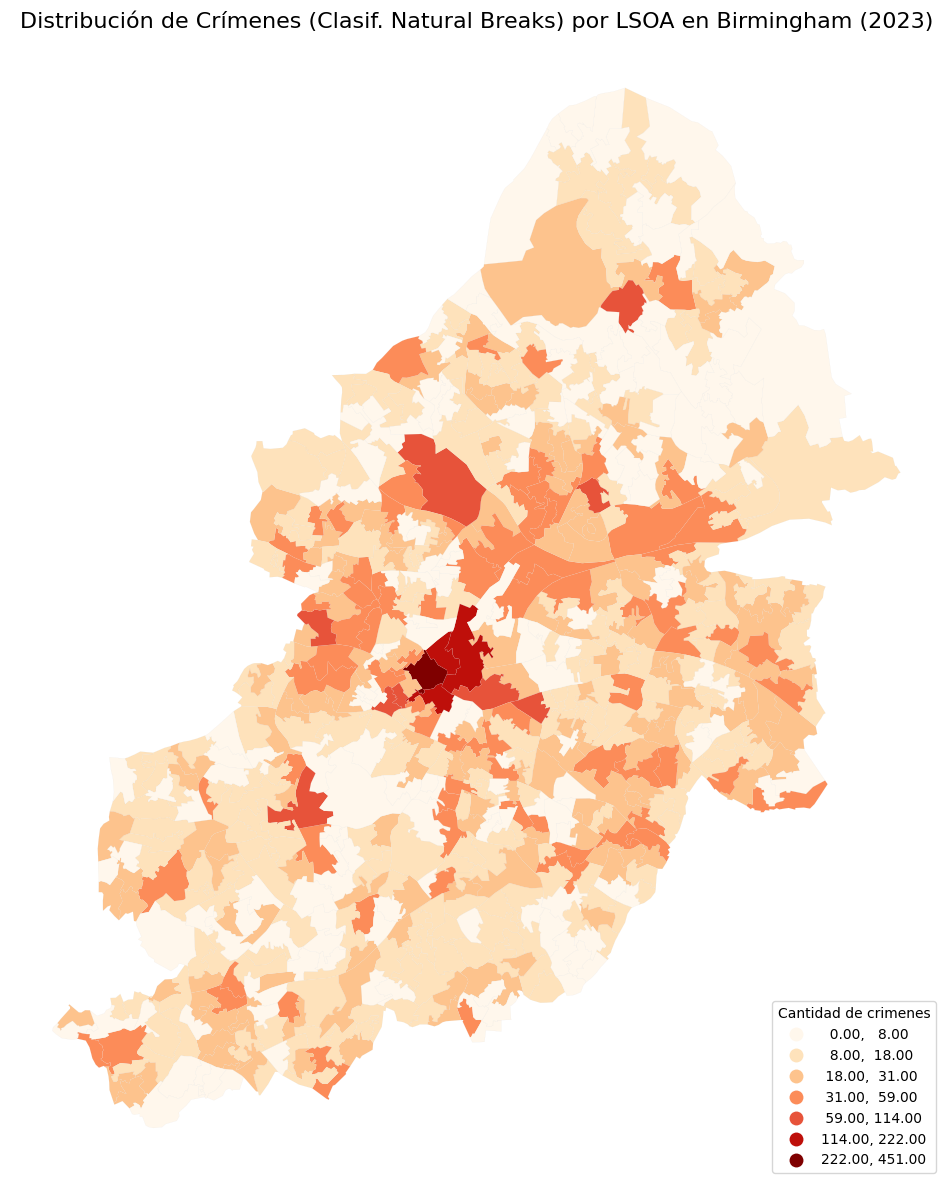

In [116]:
# --- Paso 6: Visualización - Mapa de Coropletas ---
if gdf_lsoas_with_counts is not None and not gdf_lsoas_with_counts.empty:
    try:
        fig, ax = plt.subplots(1, 1, figsize=(12, 12)) # Ajusta el tamaño según necesites

        # Dibujar el mapa usando un esquema de clasificación
        gdf_lsoas_with_counts.plot(
            column=crime_count_col,
            cmap='OrRd',
            scheme='NaturalBreaks',
            k=7,
            linewidth=0.05,
            ax=ax,
            edgecolor='lightgrey',
            legend=True,
            legend_kwds={'loc': 'lower right', 'title': 'Cantidad de crimenes'}
        )

        ax.set_title('Distribución de Crímenes (Clasif. Natural Breaks) por LSOA en Birmingham (2023)', fontsize=16)
        ax.set_axis_off()
        plt.tight_layout()

        plt.savefig(output_map_path, dpi=300, bbox_inches='tight')

        plt.show()

    except ImportError:
        print("\nPor favor, instala 'mapclassify' para usar esquemas de clasificación:")
        print("!pip install mapclassify")
    except Exception as e:
        print(f"Error al generar el mapa: {e}")
else:
    print("No se puede generar el mapa: El GeoDataFrame con conteos está vacío o no existe.")

## 6.1 Interpretación del Mapa Coropletas Total

El mapa de coropletas generado muestra la siguiente distribución aproximada de crímenes por LSOA:
*   **[0 - 8]:** Nivel Muy Bajo
*   **[8 - 18]:** Nivel Bajo
*   **[18 - 31]:** Nivel Medio-Bajo
*   **[31 - 59]:** Nivel Medio
*   **[59 - 114]:** Nivel Medio-Alto
*   **[114 - 222]:** Nivel Alto
*   **[222 - 451]:** Nivel Muy Alto / Hotspots Principales

Se observan concentraciones significativas (hotspots) principalmente en el centro de la ciudad, extendiéndose hacia el suroeste, y una concentración notable adicional al noroeste del centro. Las áreas periféricas muestran niveles considerablemente más bajos. La clasificación Natural Breaks resalta eficazmente estos patrones a pesar del sesgo en los datos.

## 7. Análisis Detallado por Tipo de Crimen
Para profundizar, se investigó si los patrones espaciales varían según el tipo de delito, analizando específicamente 'Delitos Violentos y Sexuales', 'Delitos de Vehículos' y 'Robo en Edificaciones (Burglary)'.

Se reutilizó la lógica de filtrado, agrupación y unión para añadir columnas de conteo específicas por tipo al GeoDataFrame `gdf_lsoas_with_counts`. Los resultados se visualizaron en mapas de coropletas comparativos (lado a lado), usando Natural Breaks (k=5) y paletas de color distintas para cada tipo.

In [117]:
# --- Análisis por Tipo de Crimen: Paso 1 - Explorar Tipos ---
if 'df_crimes_birmingham_city' in locals() and df_crimes_birmingham_city is not None and not df_crimes_birmingham_city.empty:
    crime_type_col = 'Crime type'

    if crime_type_col in df_crimes_birmingham_city.columns:
        crime_type_counts = df_crimes_birmingham_city[crime_type_col].value_counts() # value_counts() ordena por frecuencia descendente

    else:
        print(f"ERROR: La columna '{crime_type_col}' no se encuentra en df_crimes_birmingham_city.")
else:
    print("No se pueden explorar los tipos de crimen porque df_crimes_birmingham_city no está listo.")

In [118]:
# --- Función para agregar y unir conteos de un tipo de crimen específico ---
def add_crime_type_count(gdf_lsoas_base, df_crimes, crime_type_to_filter, crime_type_col, lsoa_code_col_csv, lsoa_code_col_geo):

    # 1. Filtrar por tipo de crimen
    df_filtered_type = df_crimes[df_crimes[crime_type_col] == crime_type_to_filter].copy()
    count_filtered = len(df_filtered_type)

    # Nombre para la nueva columna de conteo (simplificado y en minúsculas)
    new_count_col_name = crime_type_to_filter.lower().replace(' ', '_').replace('&', 'and') + '_count'

    # 2. Contar por LSOA (si hay crímenes de este tipo)
    if count_filtered > 0:
        counts = df_filtered_type.groupby(lsoa_code_col_csv).size().reset_index(name=new_count_col_name)

        # 3. Unir al GeoDataFrame base
        gdf_merged = gdf_lsoas_base.merge(
            counts,
            left_on=lsoa_code_col_geo,
            right_on=lsoa_code_col_csv,
            how='left'
        )

        # 4. Limpiar (fillna y eliminar columna redundante si es necesario)
        gdf_merged[new_count_col_name] = gdf_merged[new_count_col_name].fillna(0).astype(int)
        if lsoa_code_col_geo != lsoa_code_col_csv and lsoa_code_col_csv in gdf_merged.columns:
            gdf_merged = gdf_merged.drop(columns=[lsoa_code_col_csv])
        return gdf_merged
    else:
        print("  No se encontraron crímenes de este tipo, añadiendo columna de ceros.")
        # Si no hay crímenes, simplemente añade una columna de ceros
        gdf_lsoas_base[new_count_col_name] = 0
        return gdf_lsoas_base

In [119]:
# --- Aplicar función para cada tipo de crimen elegido ---

gdf_final_analysis = gdf_lsoas_with_counts.copy()
crime_type_col = 'Crime type'

# Lista de tipos de crimen a analizar
crime_types_to_analyze = [
    'Violence and sexual offences',
    'Vehicle crime',
    'Burglary'
]

# Aplicar la función para cada tipo
if crime_type_col in df_crimes_birmingham_city.columns:
    for crime_type in crime_types_to_analyze:
        gdf_final_analysis = add_crime_type_count(
            gdf_final_analysis,
            df_crimes_birmingham_city, # Usamos los crímenes ya filtrados por LSOAs de B'ham
            crime_type,
            crime_type_col,
            lsoa_code_col_csv,
            lsoa_code_col_geo
        )

else:
    print(f"ERROR: No se puede proceder con el análisis por tipo, la columna '{crime_type_col}' no existe.")

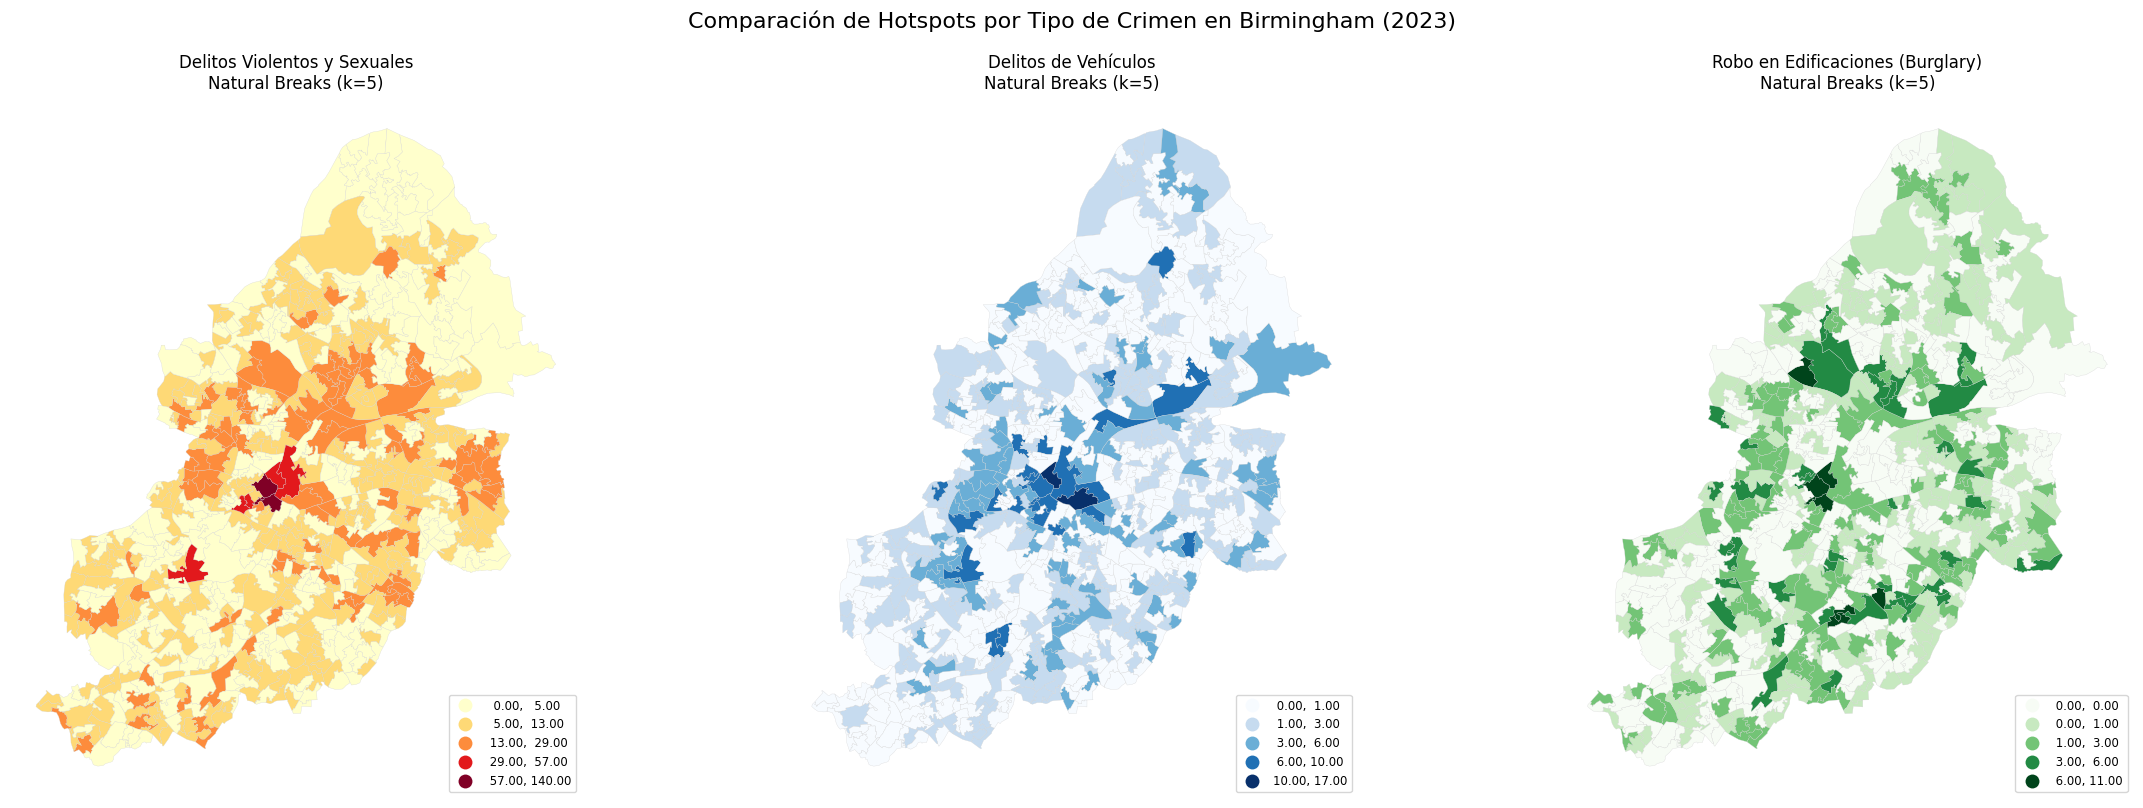

In [120]:
# --- Mapear cada tipo de crimen UNO AL LADO DEL OTRO ---

# Diccionario para traducir nombres de columna a títulos en español
titulos_mapas = {
    'violence_and_sexual_offences_count': "Delitos Violentos y Sexuales",
    'vehicle_crime_count': "Delitos de Vehículos",
    'burglary_count': "Robo en Edificaciones (Burglary)"
}

# Paletas de colores
color_maps = {
    'violence_and_sexual_offences_count': 'YlOrRd',
    'vehicle_crime_count': 'Blues',
    'burglary_count': 'Greens'
}

# Número de clases
k_classes = 5

# Nombre para el archivo de salida combinado
output_combined_filename = 'birmingham_crime_types_comparison.png'
output_combined_path = os.path.join(base_path, output_combined_filename)


if 'gdf_final_analysis' in locals() and gdf_final_analysis is not None:
    # --- Crear UNA figura con TRES subplots (1 fila, 3 columnas) ---
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    # Asegurarse de que 'axes' sea siempre un array (incluso si solo hubiera 1 subplot)
    axes = axes.flatten()

    plot_successful = True

    i = 0 # Índice para acceder a los ejes (axes[0], axes[1], axes[2])
    for count_column, cmap in color_maps.items():
        if count_column in gdf_final_analysis.columns:
            titulo_es = titulos_mapas.get(count_column, count_column.replace('_count','').replace('_',' ').title())

            try:
                # --- Dibujar en el subplot correspondiente: axes[i] ---
                gdf_final_analysis.plot(
                    column=count_column,
                    cmap=cmap,
                    scheme='NaturalBreaks',
                    k=k_classes,
                    linewidth=0.2, # Hacemos las líneas un poco más finas
                    ax=axes[i],
                    edgecolor='lightgrey',
                    legend=True,
                    legend_kwds={
                        'loc': 'lower right',
                        'fontsize': 'small'
                    }
                )

                # Título para ESTE subplot
                axes[i].set_title(f"{titulo_es}\nNatural Breaks (k={k_classes})", fontsize=12) # Título más corto
                axes[i].set_axis_off()

                i += 1

            except ImportError:
                 print("\nERROR: Falta 'mapclassify'. Instala con: !pip install mapclassify")
                 plot_successful = False
                 break
            except Exception as e:
                 print(f"Error al generar mapa para {titulo_es}: {e}")
                 plot_successful = False
        else:
            print(f"Advertencia: La columna '{count_column}' no se encontró para mapear.")
            # Podríamos querer 'desactivar' el eje correspondiente si falta un mapa
            if i < len(axes):
                axes[i].set_axis_off()
                axes[i].set_title(f"'{count_column}' no encontrada")
            i += 1


    # --- Ajustes finales, guardado y visualización (FUERA DEL BUCLE) ---
    if plot_successful and i == len(color_maps): # Solo si todos los mapas se intentaron/generaron
        # Ajustar el espaciado entre subplots para evitar superposiciones
        plt.tight_layout(pad=2.0) # Ajusta 'pad' si es necesario

        # Añadir un título general a TODA la figura (opcional)
        fig.suptitle('Comparación de Hotspots por Tipo de Crimen en Birmingham (2023)', fontsize=16, y=1.02) # y > 1 para subirlo un poco

        # Guardar la figura COMPLETA con los 3 mapas
        # try:
            # plt.savefig(output_combined_path, dpi=300, bbox_inches='tight')
            # print(f"\nMapa combinado guardado exitosamente en: {output_combined_path}")
        # except Exception as e_save:
            # print(f"\nError al guardar el mapa combinado: {e_save}")

        # Mostrar la figura COMPLETA
        plt.show()

    elif not plot_successful:
        print("\nNo se muestra ni guarda el mapa combinado debido a errores previos.")
    else:
        print("\nAdvertencia: No se generaron todos los mapas esperados.")
        plt.tight_layout(pad=2.0)
        plt.show() # Mostramos lo que se haya podido generar


    # Cerrar la figura para liberar memoria
    plt.close(fig)

else:
    print("El GeoDataFrame 'gdf_final_analysis' no está listo para mapear por tipo.")

### 7.1 Interpretación Comparativa por Tipo de Crimen

La comparación visual de los mapas por tipo de crimen revela diferencias significativas:
1.  **Delitos Violentos y Sexuales:** Concentración abrumadora en el núcleo central.
2.  **Delitos de Vehículos:** Patrón mixto de centralización y dispersión a lo largo de corredores/clusters secundarios.
3.  **Robo en Edificaciones:** Patrón notablemente más disperso, con múltiples clusters localizados y menor dependencia del centro.

Esto demuestra que la geografía del crimen en Birmingham es heterogénea y varía según el tipo de delito, lo cual tiene implicaciones para las estrategias de prevención. Es importante notar que las escalas numéricas difieren entre mapas, la comparación es de patrón relativo.

## 8. Análisis de Densidad Kernel (KDE) con QGIS

Se realizó un análisis KDE para obtener una visión continua de los hotspots, independiente de los límites LSOA.
1.  Se creó un GeoDataFrame de puntos a partir de las coordenadas de los crímenes filtrados (`df_crimes_birmingham_city`).
2.  Se reproyectaron los puntos a **EPSG:27700 (British National Grid)**.
3.  El GeoDataFrame resultante se exportó (ej. a GeoPackage) para su uso en QGIS.

In [121]:
# --- Preparar GeoDataFrame de Puntos para KDE ---

# Verificar que df_crimes_birmingham_city existe
if 'df_crimes_birmingham_city' in locals() and df_crimes_birmingham_city is not None and not df_crimes_birmingham_city.empty:

    # Nombres de columnas de coordenadas
    lat_col = 'Latitude'
    lon_col = 'Longitude'

    # Verificar que las columnas de coordenadas existen y no están vacías
    if lat_col in df_crimes_birmingham_city.columns and lon_col in df_crimes_birmingham_city.columns and \
       df_crimes_birmingham_city[lat_col].notna().any() and df_crimes_birmingham_city[lon_col].notna().any():

        try:
            # 1. Crear GeoDataFrame de Puntos desde Lat/Lon
            gdf_crime_points = gpd.GeoDataFrame(
                df_crimes_birmingham_city,
                geometry=gpd.points_from_xy(df_crimes_birmingham_city[lon_col], df_crimes_birmingham_city[lat_col]),
                crs="EPSG:4326" # Asignar CRS inicial WGS84
            )

            # 2. Reproyectar a CRS proyectado (British National Grid)
            target_crs = "EPSG:27700"
            gdf_crime_points_proj = gdf_crime_points.to_crs(target_crs)

            # 3. Exportar a GeoPackage para QGIS
            # output_gpkg_filename = 'birmingham_crime_points_proj.gpkg'
            # output_gpkg_path = os.path.join(base_path, output_gpkg_filename)
            # gdf_crime_points_proj.to_file(output_gpkg_path, driver='GPKG', layer='crime_points')
            # print(f"GeoDataFrame de puntos exportado a: {output_gpkg_path}")


        except Exception as e:
             print(f"Error durante la preparación/exportación de puntos para KDE: {e}")
    else:
        print("ERROR: Columnas de Latitud/Longitud no encontradas o vacías en df_crimes_birmingham_city.")
else:
        print("ERROR: El DataFrame 'df_crimes_birmingham_city' no está listo para preparar puntos KDE.")

### 8.1 Metodología KDE y Composición Cartográfica (QGIS)

Para generar el mapa de densidad kernel (KDE), el archivo GeoPackage con los puntos de crimen proyectados (`birmingham_crime_points_proj.gpkg`) se cargó como una capa vectorial en **QGIS (versión 3.40.3 - Bratislava)**.

Se utilizó la herramienta **"Mapa de Calor (Kernel Density Estimation)"** de la Caja de Herramientas de Procesos con la siguiente configuración, buscando un equilibrio entre el detalle local y la visualización de patrones generales:
*   **Capa de Puntos de Entrada:** `crime_points` (del GeoPackage).
*   **Radio (Bandwidth):** **250 metros**. Este valor se determinó mediante experimentación visual para suavizar el ruido excesivo sin perder la estructura de los hotspots secundarios.
*   **Tamaño de Píxel de Salida:** **10 metros**. Proporciona una buena resolución visual para la escala del análisis.
*   **Kernel:** Gaussiano (predeterminado).
*   **Archivo Ráster de Salida:** El resultado se guardó como un archivo GeoPackage.

El ráster de densidad resultante se estilizó directamente en QGIS para crear el mapa de calor:
*   **Renderizador:** Se utilizó "Pseudocolor monobanda".
*   **Rampa de Color:** Se seleccionó una rampa `RdYlBu` (Rojo-Amarillo-Azul) o similar, **invertida** para que los valores altos de densidad correspondieran a los colores cálidos (rojo intenso).
*   **Transparencia:** Se aplicó **100% de transparencia a los valores de densidad más bajos** (cercanos a cero) para ocultar las áreas de mínima incidencia y hacer resaltar visualmente los hotspots sobre el mapa base.
*   **Mapa Base:** Se utilizó el mapa base minimalista **CartoDB Positron** para proporcionar contexto geográfico sin competir visualmente con la capa de densidad.

Finalmente, se creó una **Composición de Impresión** en QGIS para generar el producto cartográfico final:
*   **Elementos Incluidos:** Se añadieron y organizaron los elementos cartográficos esenciales: el mapa principal (KDE sobre el mapa base), un título descriptivo, una flecha de norte, una barra de escala gráfica (en kilómetros) y un bloque de texto detallado con la leyenda (valores Mín/Máx de densidad), las fuentes de datos completas (incluyendo mapa base y atribuciones a OpenStreetMap y CARTO), la autoría, la fecha, el CRS utilizado (EPSG:27700) y los parámetros específicos del KDE (Radio y Tamaño de Píxel).
*   **Exportación:** La composición final se exportó como una imagen **PNG a 300 ppp** para asegurar alta calidad para su inclusión en este documento y el repositorio.

![Mapa final de Densidad de Crímenes (KDE) en Birmingham (2023) generado en QGIS](https://drive.google.com/uc?id=1E_TZOkO31kgiPvQiwzVMjcQ4eHXQUxUz)

### 8.2 Interpretación del Mapa KDE y Comparación

El mapa de Densidad Kernel (KDE) ofrece una perspectiva valiosa y complementaria a los mapas de coropletas basados en LSOA, al visualizar la concentración de crímenes como una superficie continua, independiente de los límites administrativos.

**Observaciones Principales del Mapa KDE:**

*   **Hotspot Central Dominante:** El KDE confirma de manera contundente la existencia de un **área de muy alta densidad (rojo intenso)** en el **centro neurálgico de Birmingham**. Esta zona aparece como el foco principal de concentración de crímenes en toda la ciudad.
*   **Hotspots Secundarios Claros:** Además del núcleo central, el mapa revela numerosos **hotspots secundarios bien definidos (naranja/amarillo)**. Estos aparecen dispersos en diferentes partes de la ciudad, algunos cercanos al centro, otros en áreas más periféricas o a lo largo de corredores viales importantes visibles en el mapa base. La transparencia aplicada a los valores bajos ayuda a delimitar claramente estas zonas de mayor actividad.
*   **Patrón General:** Más allá de los picos, se observa una **amplia extensión de densidad media-baja (azul claro/cyan)** que cubre gran parte del área urbana, indicando una presencia generalizada de incidentes, pero con una clara tendencia a aglomerarse en los puntos mencionados anteriormente.

**Comparación con los Mapas de Coropletas LSOA:**

*   **Confirmación del Centro:** El intenso hotspot central del KDE **se alinea perfectamente** con los LSOAs identificados con los conteos más altos en el mapa de coropletas *general* y, de manera muy significativa, en el mapa de coropletas específico de *Delitos Violentos y Sexuales*. Esto refuerza la idea de que el centro de la ciudad es el epicentro principal de la criminalidad reportada, especialmente para ciertos tipos de delitos.
*   **Refinamiento de Hotspots LSOA:** El KDE proporciona **mayor detalle sobre la estructura *interna*** de los hotspots. Mientras que un LSOA completo aparecía en rojo oscuro en el coropletas, el KDE puede mostrar que la alta densidad dentro de ese LSOA se concentra en una parte específica (ej. una calle principal, un área comercial) en lugar de ser uniforme en todo el polígono.
*   **Visualización de Continuidad y Límites:** El KDE muestra cómo las zonas de alta densidad a menudo **se extienden a través de las fronteras de los LSOA**, creando un patrón más orgánico. Esto contrasta con los cambios abruptos de color en los límites LSOA del coropletas, sugiriendo que los fenómenos delictivos no siempre respetan estas divisiones administrativas.
*   **Comparación con Tipos Específicos:**
    *   El KDE general captura bien la centralización vista en *Delitos Violentos/Sexuales* y parte de los *Delitos de Vehículos*.
    *   Los numerosos hotspots secundarios del KDE podrían correlacionarse tanto con los clusters secundarios de *Delitos de Vehículos* como con los clusters más dispersos de *Robo en Edificaciones*, aunque se necesitaría un análisis KDE específico por tipo para confirmarlo plenamente. El KDE general, al agregar todos los crímenes, tiende a estar dominado visualmente por los tipos más frecuentes.

**Conclusión del KDE:**

El análisis de Densidad Kernel complementa eficazmente la visión proporcionada por los mapas de coropletas. Ofrece una representación espacial continua y más detallada de la concentración del crimen, confirmando los principales focos de actividad pero revelando también la estructura fina de los hotspots y su independencia de los límites administrativos. La combinación de ambos enfoques (agregado por área y densidad de puntos) proporciona una comprensión más robusta y matizada de la geografía del crimen en Birmingham.

## 9. Análisis de Proximidad a Puntos de Interés (POI)

Para explorar posibles factores relacionados con la ubicación de los crímenes, se realizó un análisis de proximidad a diferentes tipos de Puntos de Interés (POI). El objetivo era cuantificar qué proporción de los crímenes reportados ocurría en el entorno inmediato de lugares específicos como bares/pubs, comisarías de policía y estaciones de transporte.

### 9.1 Obtención y Preparación de Datos POI

1.  **Obtención:** Se utilizaron datos de OpenStreetMap (OSM) descargados mediante la librería `osmnx` en Python. Se buscaron nodos o polígonos etiquetados como `amenity=bar`, `amenity=pub`, `amenity=police` y `public_transport=station` dentro del área de Birmingham.
2.  **Limpieza y Clasificación:** El GeoDataFrame resultante se limpió para mantener columnas relevantes (geometría, nombre, tags OSM) y se creó una columna `poi_type` para clasificar cada POI como 'Bar/Pub', 'Police' o 'Station'. Se descartaron los POIs que no correspondían a estas categorías.
3.  **Reproyección:** Al igual que los puntos de crimen, los POIs se reproyectaron al CRS **EPSG:27700 (British National Grid)** para permitir análisis de distancia en metros.

In [122]:
# --- Paso 1: Obtención de datos ---
place_name = "Birmingham, UK"

tags = {'amenity': ['bar', 'pub', 'police'],'public_transport': 'station'}

try:
    gdf_pois = ox.features_from_place(place_name, tags)

except Exception as e:
    print(f"No se pudieron descargar POIs para {tags} en {place_name}: {e}")
    gdf_pois = None

# --- Paso 2: Limpieza y clasificación ---

if 'gdf_pois' in locals() and gdf_pois is not None:

    cols_to_keep = ['geometry', 'name', 'amenity', 'public_transport']
    existing_cols_to_keep = [col for col in cols_to_keep if col in gdf_pois.columns]
    gdf_pois_clean = gdf_pois[existing_cols_to_keep].copy()

    # Asegurarse que las columnas usadas en conditions existen y son string (o convertir NaN a algo manejable)
    if 'amenity' in gdf_pois_clean.columns:
      gdf_pois_clean['amenity'] = gdf_pois_clean['amenity'].astype(str).fillna('') # Convertir a string, NaN a ''
    else:
      gdf_pois_clean['amenity'] = '' # Crear columna vacía si no existe

    if 'public_transport' in gdf_pois_clean.columns:
       gdf_pois_clean['public_transport'] = gdf_pois_clean['public_transport'].astype(str).fillna('') # Convertir a string, NaN a ''
    else:
       gdf_pois_clean['public_transport'] = '' # Crear columna vacía si no existe


    conditions = [
        gdf_pois_clean['amenity'].isin(['bar', 'pub']),
        gdf_pois_clean['amenity'] == 'police',
        gdf_pois_clean['public_transport'] == 'station'
    ]
    choices = ['Bar/Pub', 'Police', 'Station']
    gdf_pois_clean['poi_type'] = np.select(conditions, choices, default=None)

    # Filtrar solo los POIs que pudimos clasificar
    gdf_pois_clean = gdf_pois_clean[gdf_pois_clean['poi_type'].notna()]

    target_crs = "EPSG:27700"
    if gdf_pois_clean.crs != target_crs:
        gdf_pois_proj = gdf_pois_clean.to_crs(target_crs)
    else:
        gdf_pois_proj = gdf_pois_clean

else:
    print("ERROR: El GeoDataFrame 'gdf_pois' no está disponible. Descárgalo o cárgalo primero.")
    gdf_pois_proj = None

### 9.2 Metodología: Buffers y Unión Espacial

Se aplicó un análisis de buffers para cada tipo de POI seleccionado:

1.  **Creación de Buffers:** Para cada tipo de POI ('Bar/Pub', 'Police', 'Station'), se generó un área de influencia (buffer) poligonal de **100 metros** alrededor de cada punto POI.
2.  **Disolución:** Los buffers que se solapaban (ej., bares muy cercanos) se disolvieron en una única geometría MultiPolygon para evitar el doble conteo de crímenes.
3.  **Unión Espacial:** Se realizó una unión espacial entre el GeoDataFrame de **puntos de crimen** proyectados (`gdf_crime_points_proj`) y los **polígonos de buffer disueltos** para cada tipo de POI. Se utilizó el predicado `within` para seleccionar únicamente los crímenes cuyo punto caía estrictamente dentro del área del buffer.
4.  **Cálculo de Resultados:** Se contó el número de crímenes dentro de los buffers para cada tipo de POI y se calculó el porcentaje que representaban respecto al total de crímenes analizados en Birmingham. Adicionalmente, se realizó un desglose por tipo de crimen para los incidentes ocurridos dentro de los buffers.

*(Nota: Se realizó una prueba adicional con buffers de 150m para Bares/Pubs, que mostró un aumento al 22.5% de crímenes cercanos, sugiriendo una influencia que se extiende ligeramente más allá de los 100m inmediatos, aunque se mantuvo 100m para la comparación principal.)*

In [123]:
# --- Paso 3: Analizar Proximidad para Múltiples Tipos de POI ---

# -- Configuración del Análisis --
poi_analysis_config = {
    'Bar/Pub': 'Bares/Pubs',
    'Police': 'Comisarías de Policía',
    'Station': 'Estaciones de Transporte'
}

buffer_distance_meters = 100  # Distancia común para comparar todos los tipos
total_crimes = len(gdf_crime_points_proj) if 'gdf_crime_points_proj' in locals() and gdf_crime_points_proj is not None else 0
all_results = {} # Diccionario para guardar todos los resultados numéricos
all_type_counts = {} # Diccionario para guardar los desgloses por tipo de crimen

# -- Verificación Previa --
if total_crimes == 0 or 'gdf_pois_proj' not in locals() or gdf_pois_proj is None:
    print("ERROR: Faltan los GeoDataFrames proyectados de crímenes o POIs. No se puede continuar.")
else:
    # -- Bucle Principal --
    for poi_type, poi_title in poi_analysis_config.items():

        # 1. Filtrar POIs del tipo actual
        gdf_target_pois = gdf_pois_proj[gdf_pois_proj['poi_type'] == poi_type].copy()

        if not gdf_target_pois.empty:
            # 2. Crear Buffers
            gdf_target_pois['geometry'] = gdf_target_pois.geometry.buffer(buffer_distance_meters)

            # 3. Disolver Buffers Solapados
            try:
                dissolved_buffers = gdf_target_pois.dissolve(by='poi_type') # Usamos poi_type que es constante aquí
            except Exception as e_dissolve:
                print(f"  Advertencia: No se pudieron disolver buffers: {e_dissolve}. Usando buffers individuales.")
                dissolved_buffers = gdf_target_pois

            # 4. Unión Espacial: Crímenes DENTRO de los buffers
            crimes_in_buffers = gpd.sjoin(gdf_crime_points_proj, dissolved_buffers, how="inner", predicate='within')

            # 5. Calcular y Guardar Resultados Numéricos
            count_crimes_in_buffers = len(crimes_in_buffers)
            percentage_in_buffers = (count_crimes_in_buffers / total_crimes) * 100

            results = {
                'poi_type_analyzed': poi_title,
                'buffer_distance_m': buffer_distance_meters,
                'total_crimes_birmingham': total_crimes,
                'crimes_in_buffer': count_crimes_in_buffers,
                'percentage_in_buffer': percentage_in_buffers
            }
            all_results[poi_type] = results # Guardar resultados para este tipo

            # 6. Desglose por Tipo de Crimen (si hay crímenes en buffer)
            if not crimes_in_buffers.empty:
                 crime_type_col = 'Crime type'
                 if crime_type_col in crimes_in_buffers.columns:
                      type_counts = crimes_in_buffers[crime_type_col].value_counts()
                      all_type_counts[poi_type] = type_counts # Guardar desglose
                 else:
                       print(f"    Advertencia: Columna '{crime_type_col}' no encontrada para desglose.")
                       all_type_counts[poi_type] = None
            else:
                 all_type_counts[poi_type] = None


        else:
            print(f"  No se encontraron POIs del tipo '{poi_type}'. Saltando análisis para este tipo.")
            # Guardar resultados nulos para mantener consistencia si es necesario
            all_results[poi_type] = { 'poi_type_analyzed': poi_title, 'crimes_in_buffer': 0, 'percentage_in_buffer': 0.0 }
            all_type_counts[poi_type] = None


    # -- Fin del Bucle --


--- Gráfico 1: Porcentaje de Crímenes Totales en Buffers (100m) ---


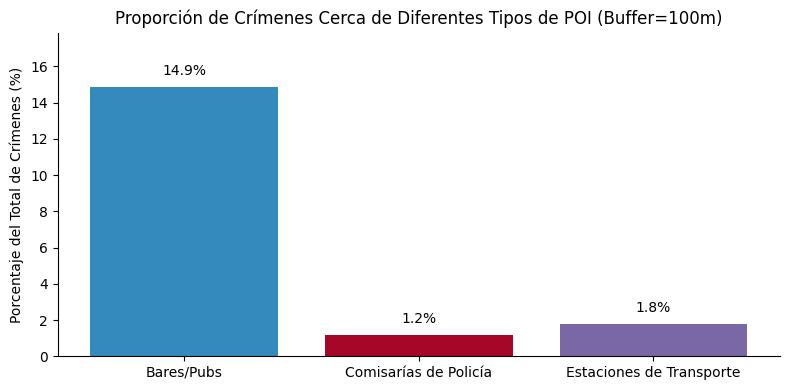


--- Gráfico 2: Desglose de Tipos de Crimen Frecuentes en Buffers (100m) ---


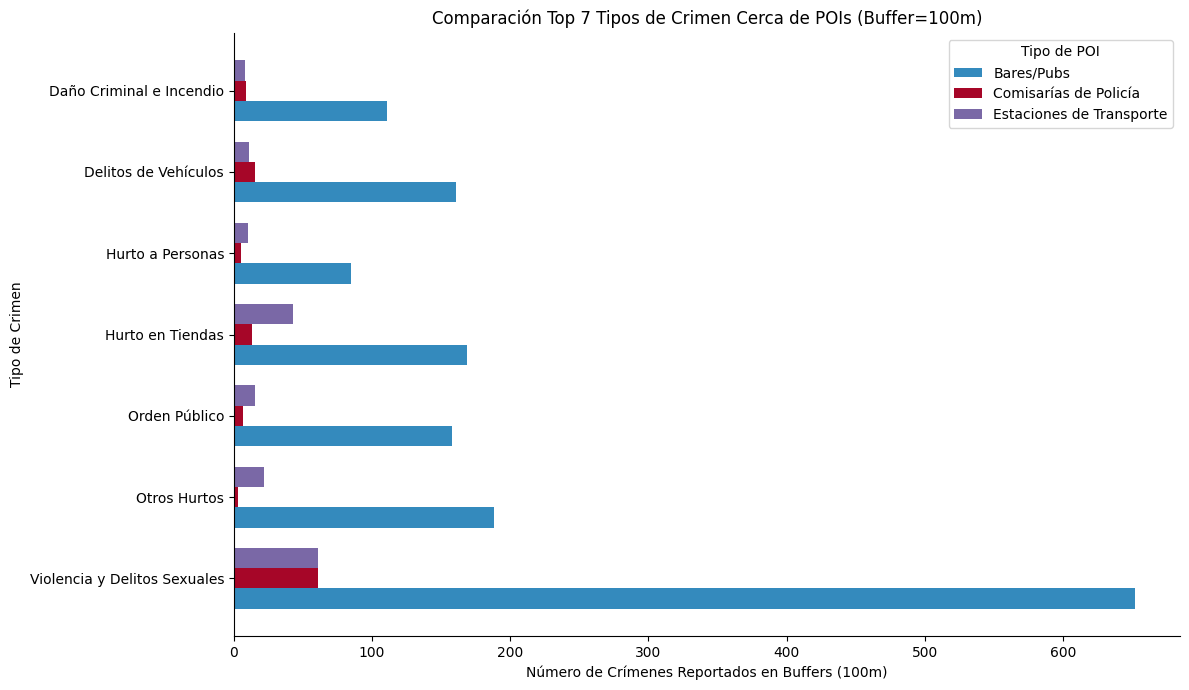

In [126]:
# --- Paso 4: Visualización Comparativa del Análisis de Proximidad ---

# Verificar que los resultados existen
if 'all_results' not in locals() or not all_results or \
   'all_type_counts' not in locals() or not all_type_counts:
    print("ERROR: Los diccionarios 'all_results' o 'all_type_counts' no se generaron correctamente.")
else:
    # --- Gráfico 1: Comparación de Porcentaje Total en Buffers ---

    print("\n--- Gráfico 1: Porcentaje de Crímenes Totales en Buffers (100m) ---")
    try:
        # Extraer datos relevantes del diccionario de resultados
        poi_types = [res['poi_type_analyzed'] for res in all_results.values()]
        percentages = [res['percentage_in_buffer'] for res in all_results.values()]

        fig1, ax1 = plt.subplots(figsize=(8, 4)) # Ajusta tamaño si es necesario

        # Crear barras
        bars1 = ax1.bar(poi_types, percentages, color=['#348ABD', '#A60628', '#7A68A6']) # Colores ejemplo

        # Añadir porcentajes encima de las barras
        for bar in bars1:
            yval = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval:.1f}%', va='bottom', ha='center', fontsize=10)

        # Títulos y etiquetas
        ax1.set_ylabel('Porcentaje del Total de Crímenes (%)')
        ax1.set_ylim(0, max(percentages) * 1.2) # Ajustar límite Y
        ax1.set_title('Proporción de Crímenes Cerca de Diferentes Tipos de POI (Buffer=100m)', fontsize=12)
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

        plt.tight_layout()
        plt.savefig(os.path.join(base_path, 'poi_comparison_percentage.png'), dpi=300) # Opcional: guardar
        plt.show()
        plt.close(fig1)

    except Exception as e:
        print(f"Error generando Gráfico 1: {e}")


    # --- Gráfico 2: Comparación Desglose Tipos de Crimen (Barras Agrupadas - ETIQUETAS ESPAÑOL) ---

    print("\n--- Gráfico 2: Desglose de Tipos de Crimen Frecuentes en Buffers (100m) ---")
    try:
        # 1. Preparar los datos para barras agrupadas (igual que antes)
        all_counts_combined = pd.concat(all_type_counts.values()).groupby(level=0).sum().nlargest(7) # Top 7 tipos
        top_crime_types_en = all_counts_combined.index.tolist() # Nombres originales en inglés

        plot_data = {}
        for poi_type, poi_title in poi_analysis_config.items():
            if all_type_counts[poi_type] is not None:
                plot_data[poi_title] = all_type_counts[poi_type].reindex(top_crime_types_en).fillna(0)
            else:
                plot_data[poi_title] = pd.Series(0, index=top_crime_types_en)

        df_plot = pd.DataFrame(plot_data)

        # --- TRADUCCIÓN DE ETIQUETAS ---
        traduccion_crimenes = {
            'Violence and sexual offences': 'Violencia y Delitos Sexuales',
            'Other theft': 'Otros Hurtos',
            'Shoplifting': 'Hurto en Tiendas',
            'Vehicle crime': 'Delitos de Vehículos',
            'Public order': 'Orden Público',
            'Criminal damage and arson': 'Daño Criminal e Incendio',
            'Theft from the person': 'Hurto a Personas',
            'Anti-social behaviour': 'Comportamiento Antisocial',
            'Burglary': 'Robo en Edificaciones',
            'Robbery': 'Robo con Violencia',
            'Drugs': 'Drogas',
            'Possession of weapons': 'Posesión de Armas',
            'Other crime': 'Otros Delitos',
            'Bicycle theft': 'Robo de Bicicletas'
        }

        # Aplicar traducción al índice del DataFrame (nombres de crímenes)
        df_plot.index = [traduccion_crimenes.get(label, label) for label in df_plot.index]


        df_plot = df_plot.sort_index(ascending=False) # Ordenar alfabéticamente en español

        # 2. Configurar gráfico de barras agrupadas
        n_pois = len(df_plot.columns)
        n_crimes = len(df_plot.index)
        bar_width = 0.25
        index = np.arange(n_crimes)

        fig2, ax2 = plt.subplots(figsize=(12, 7))

        colors = ['#348ABD', '#A60628', '#7A68A6']

        # Dibujar las barras para cada tipo de POI
        for i, poi_title in enumerate(df_plot.columns):
            bar_positions = index + i * bar_width
            ax2.barh(bar_positions, df_plot[poi_title], bar_width, label=poi_title, color=colors[i % len(colors)])


        # Títulos y etiquetas (Ahora set_yticklabels usa el índice traducido)
        ax2.set_xlabel('Número de Crímenes Reportados en Buffers (100m)')
        ax2.set_ylabel('Tipo de Crimen')
        ax2.set_yticks(index + bar_width * (n_pois-1) / 2)
        ax2.set_yticklabels(df_plot.index) # <-- Usa el índice ya traducido
        ax2.set_title(f'Comparación Top {len(df_plot.index)} Tipos de Crimen Cerca de POIs (Buffer=100m)', fontsize=12)
        ax2.legend(title='Tipo de POI')
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)

        plt.tight_layout()
        plt.savefig(os.path.join(base_path, 'poi_comparison_typedesglose_es.png'), dpi=300) # Opcional: guardar
        plt.show()
        plt.close(fig2)

    except Exception as e:
        print(f"Error generando Gráfico 2: {e}")

### 9.3 Interpretación de Resultados POI
Los resultados del análisis de proximidad (Buffer=100m) son reveladores:

* **Proximidad a Bares/Pubs:** Una proporción muy significativa, **casi el 15%**, del total de crímenes reportados en Birmingham ocurren en el entorno inmediato (<100m) de bares y pubs. El desglose por tipo de crimen muestra que esta asociación es especialmente fuerte para '**Delitos Violentos y Sexuales'**, pero también relevante para hurtos, delitos de vehículos, orden público y daño criminal. Esto sugiere que las zonas de ocio nocturno son importantes focos de concentración para una variedad de incidentes.

* **Proximidad a Comisarías y Estaciones:** En marcado contraste, solo un **1.2%** de los crímenes ocurren cerca de comisarías y un **1.8%** cerca de estaciones de transporte (a 100m). Si bien esto no implica ausencia de crimen, sí indica que la densidad relativa o la proporción del crimen total es mucho menor en estas áreas comparada con los entornos de bares/pubs. Para las comisarías, esto podría reflejar un cierto efecto disuasorio o simplemente una menor cantidad de oportunidades comparado con zonas de alta afluencia de público.

**Conclusión del Análisis POI:** Este análisis sugiere una fuerte correlación espacial entre la ubicación de bares/pubs y la incidencia delictiva, especialmente para delitos violentos/sexuales. Las comisarías y estaciones de transporte no muestran una concentración similar del crimen general a esta escala de proximidad. Este hallazgo añade otra capa de comprensión a la geografía del crimen en la ciudad.

## 10. Conclusiones Generales y Trabajo Futuro

Este proyecto proporciona un análisis multifacético de la distribución espacial del crimen en Birmingham durante 2023, utilizando diferentes enfoques complementarios:

1.  **Análisis por LSOA (Coropletas):** Identificó las unidades administrativas con mayor número de incidentes, tanto de forma agregada como desglosada por tipo de crimen ('Delitos Violentos y Sexuales', 'Delitos de Vehículos', 'Robo en Edificaciones'), revelando **patrones espaciales diferenciados** para cada categoría.
2.  **Análisis de Densidad Kernel (KDE):** Ofreció una visión continua y detallada de los hotspots, confirmando la fuerte concentración en el centro de la ciudad pero también mostrando la estructura fina de los focos de alta densidad y su independencia de los límites LSOA.
3.  **Análisis de Proximidad a POI:** Cuantificó la concentración del crimen alrededor de puntos de interés clave, destacando una **fuerte correlación entre la proximidad a bares/pubs y una alta incidencia delictiva (casi 15% del total a <100m)**, especialmente para delitos violentos/sexuales, en contraste con la baja concentración cerca de comisarías y estaciones de transporte.

En conjunto, los resultados pintan un cuadro complejo de la geografía del crimen en Birmingham, donde un núcleo central denso coexiste con hotspots secundarios y patrones específicos ligados tanto al tipo de delito como a las características del entorno (como la presencia de locales de ocio). La combinación de técnicas de agregación por área, densidad de puntos y análisis de proximidad ha permitido obtener una comprensión más rica y matizada.

**Trabajo Futuro:**

*   **Otros Tipos de POI:** Analizar la proximidad a otros puntos como parques, escuelas o centros comerciales.
*   **Factores Socioeconómicos:** Incorporar datos LSOA sobre demografía o privación para explorar correlaciones con las tasas de crimen.
*   **Análisis Temporal:** Investigar variaciones diurnas, semanales o estacionales en los patrones de hotspots o en la proximidad a POIs.
*   **Modelado Predictivo:** Utilizar los patrones identificados y potencialmente otros predictores espaciales para construir modelos que estimen el riesgo delictivo.
*   **Visualizaciones Interactivas:** Desarrollar mapas interactivos (ej. `folium`) para permitir una exploración más dinámica de los datos.